# Initialization

In [78]:
from src.SIV_library.lib import SIV, OpticalFlow
from src.SIV_library.plots import plot_flow
from src.SIV_library.advanced import ctf_optical, match_refine, Warp
from torchPIV import OfflinePIV

import os
import sys
import torch
import matplotlib.pyplot as plt

plt.rcParams["animation.html"] = "jshtml"
# %matplotlib notebook
%matplotlib inline

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

if device == "cuda":
    torch.cuda.empty_cache()
    
folder = "../Test Data/gg"

device: cuda


# TorchPIV

In [80]:
piv_gen = OfflinePIV(
    folder=folder, # Path to experiment
    device=torch.cuda.get_device_name(), # Device name
    file_fmt="tif",
    wind_size=64,
    overlap=32,
    dt=12, # Time between frames, mcs
    scale = 0.02, # mm/pix
    multipass=2,
    multipass_mode="DWS", # CWS or DWS
    multipass_scale=2.0, # Window downscale on each pass
    folder_mode="sequential" # Pairs or sequential frames 
)

for out in piv_gen():
    x, y, vx, vy = out
    x, y = x/piv_gen._scale, y/piv_gen._scale

Load time 0.004 sec Iteration finished in 0.044 sec Warning! to many false vectors
Warning! to many false vectors
Batch finished in 0.071 sec


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

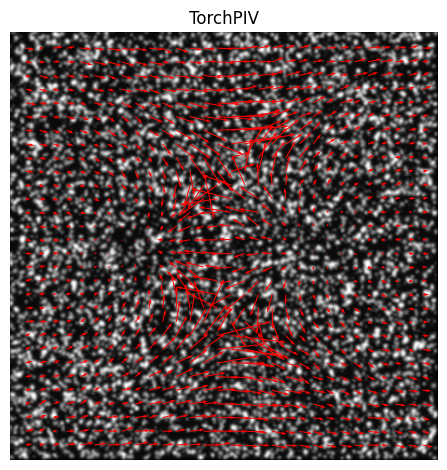

Traceback (most recent call last):
  File "C:\Users\ruben\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py", line 298, in process
    func(*args, **kwargs)
  File "C:\Users\ruben\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\animation.py", line 924, in _stop
    self.event_source.remove_callback(self._step)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [81]:
# plt.close('all')

fig, ax = plt.subplots(1, 1)
 
frame = piv_gen._dataset[0][0]
ax.imshow(frame, cmap='gray')
ax.quiver(x, y, vx, -vy, color='red', scale=0.05, scale_units='xy', angles='xy')

ax.set_title(f'TorchPIV')
ax.set_axis_off()

fig.tight_layout()
plt.show()

# Matching

In [82]:
mode = 1
t = SIV(folder, device, 128, 64, (10, 10, 10, 10), mode=mode, num_passes=4, scale_factor=0.5)

In [83]:
x0, y0, u0, v0 = t.run()

SAD: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]


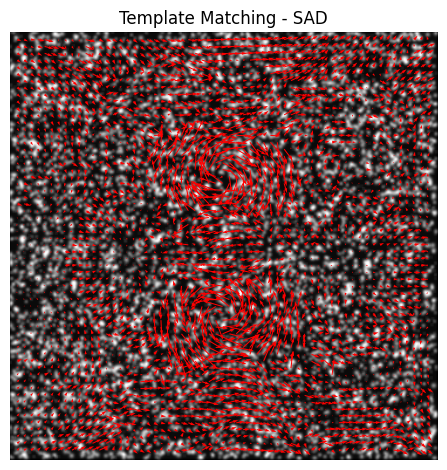

In [84]:
# plt.close('all')

fig, ax = plt.subplots(1, 1)

x0, y0, u0, v0 = x0.cpu(), y0.cpu(), u0.cpu(), v0.cpu()
 
frame = t.dataset[0][0].cpu().numpy()
ax.imshow(frame, cmap='gray')
ax.quiver(x0[0].numpy(), y0[0].numpy(), u0[0].numpy(), -v0[0].numpy(), color='red', scale=0.1, scale_units='xy', angles='xy')

ax.set_title(f'Template Matching - {"SAD" if mode == 1 else "Correlation"}')
ax.set_axis_off()

fig.tight_layout()
plt.show()

Interpolate velocity field:

In [85]:
w = Warp(x0, y0, u0, v0)
w.interpolate_field(t.dataset.img_shape)
x1, y1, u1, v1 = w.x, w.y, w.u, w.v

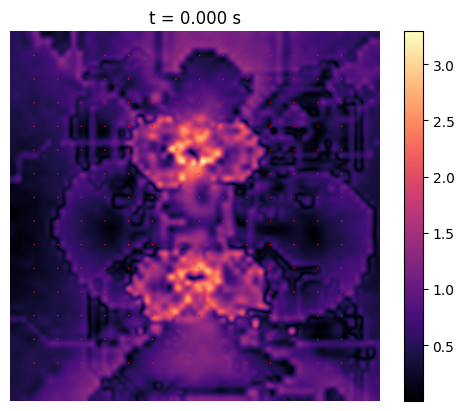

In [86]:
# plt.close('all')
_ = plot_flow(u1, v1, grid_spacing=32, fn=None)

# Optical flow

In [87]:
u = OpticalFlow(folder, device, 100., 1000, 0.)

In [88]:
x2, y2, u2, v2 = u.run()

Optical flow: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


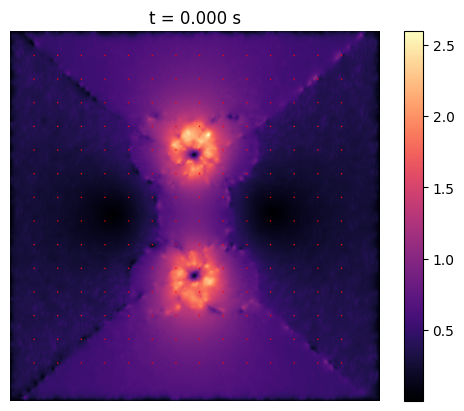

In [89]:
# plt.close('all')
_ = plot_flow(u2, v2, grid_spacing=32, fn=None)

Course-to-fine optical flow:

In [90]:
x3, y3, u3, v3 = ctf_optical(u, num_passes=3, scale_factor=1/2)

Optical flow: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


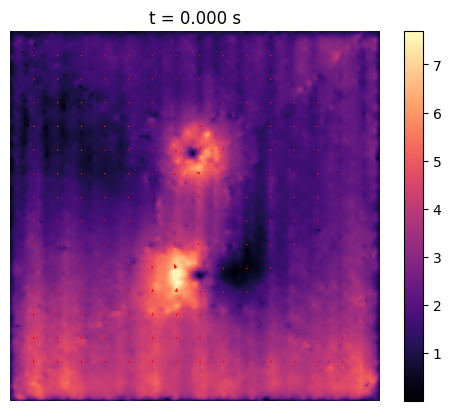

In [91]:
# plt.close('all')
_ = plot_flow(u3, v3, grid_spacing=32, fn=None)

# Hybrid method (matching + optical flow)

In [92]:
x4, y4, u4, v4 = match_refine(t, u)

Optical flow: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


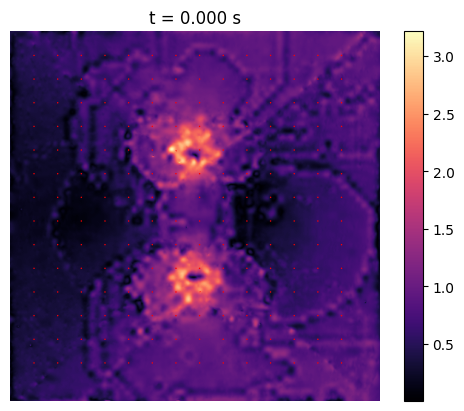

In [93]:
# plt.close('all')
_ = plot_flow(u4, v4, grid_spacing=32, fn="../experiments/hybrid.gif")